# IMPORTS

In [16]:
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import fetch_covtype
import numpy as np
from sklearn.metrics import normalized_mutual_info_score
import time
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# used only to plot summary plots
import pandas as pd
import seaborn as sns

# DATA PREP

In [3]:
# We load the covertype dataset
data = fetch_covtype()
X_temp = data.data
y = data.target  # ground truth labels (1–7)

# We standardize the features (important for k-means)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_temp)

X = X_scaled

print(X.shape)
print(y.shape)
print(set(list(y)))

(581012, 54)
(581012,)
{np.int32(1), np.int32(2), np.int32(3), np.int32(4), np.int32(5), np.int32(6), np.int32(7)}


# PART 1 (Lloyd’s Algorithm)

In [17]:
def lloyds_algorithm(X, k):
    samples_size, _ = X.shape

    # We need a copy so that we dont alter X
    centers = X[:k].copy()

    # An array that contains numbers at each position i depending on which cluster sample[i] was placed
    assignment_array = np.zeros(samples_size, dtype=int)

    # The distances that each sample has from each one of the k clusters
    distances = np.zeros((samples_size, k))

    # Will be set to True once we see that no cluster is being changed
    converge = False
    
    iterations = 0
    #total_distance_computations = 0
    covergence_list = []

    while not converge:
        # Compute distances from points to centers
        for i in range(k):
            distances[:, i] = np.linalg.norm(X - centers[i], axis=1)
        #total_distance_computations += samples_size * k

        # Assign labels to the samples
        new_assignment = np.argmin(distances, axis=1)
        # We will use the sum of the minimum distance (aka the distance from the assigned cluster) squared 
        # to show convergence
        covergence = np.sum(np.min(distances, axis=1)**2)
        covergence_list.append(covergence)

        # Check for convergence
        if np.array_equal(assignment_array, new_assignment):
            converge = True
        assignment_array = new_assignment

        # Update the cluster centers
        for i in range(k):
            # any check just to avoid some errors
            if np.any(assignment_array == i):
                centers[i] = X[assignment_array == i].mean(axis=0)

        iterations += 1

    total_computations = iterations * samples_size * k

    return assignment_array, centers, iterations, total_computations, covergence_list



def run_kmeans_evaluation(X, y, k, runs=5):
    nmi_scores = []
    runtimes = []
    iterations_list = []
    dist_counts = []
    covergence_all_runs = []

    for _ in range(runs):
        start_time = time.time()
        assignments, centers, iterations, total_computations, covergence = lloyds_algorithm(X, k)
        end_time = time.time()

        nmi = normalized_mutual_info_score(y, assignments, average_method="arithmetic")
        runtime = end_time - start_time

        nmi_scores.append(nmi)
        runtimes.append(runtime)
        iterations_list.append(iterations)
        dist_counts.append(total_computations)
        covergence_all_runs.append(covergence)

    # Plot convergence for the first run
    plt.figure()
    plt.plot(covergence_all_runs[0])
    plt.title(f"K-Means Convergence (k={k})")
    plt.xlabel("Iteration")
    plt.ylabel("Sum of Squared Distances")
    plt.grid(True)
    plt.show()

    print(f"\n------ Results for k={k} ------")
    print(f"Average NMI: {np.mean(nmi_scores):.3f}")
    print(f"Average Runtime: {np.mean(runtimes):.3f} s")
    print(f"Average Iterations: {int(np.mean(iterations_list))}")
    print(f"Average Distance Computations: {int(np.mean(dist_counts))}")
    print(f"Total Distance Computations: {np.sum(dist_counts)}")

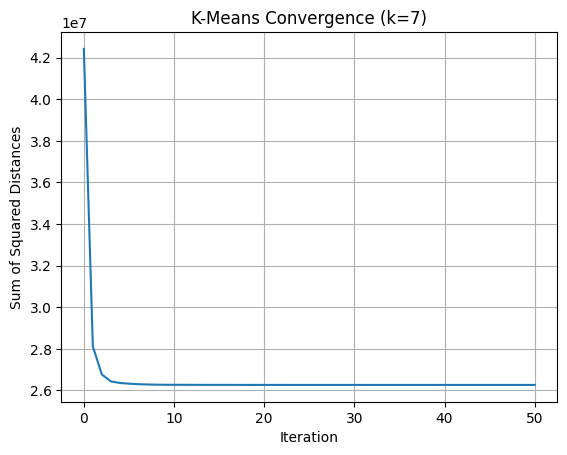


------ Results for k=7 ------
Average NMI: 0.101
Average Runtime: 52.068 s
Average Iterations: 51
Average Distance Computations: 207421284
Total Distance Computations: 1037106420


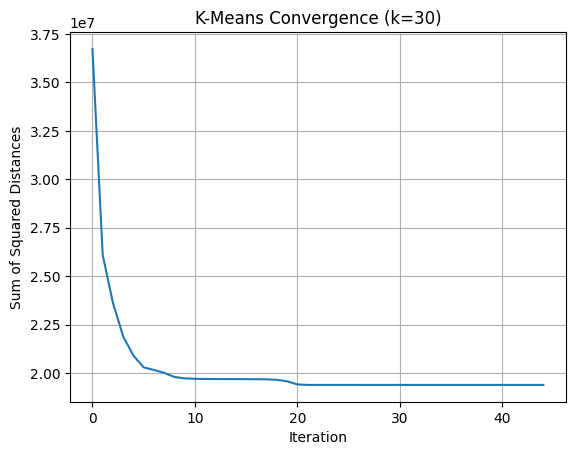


------ Results for k=30 ------
Average NMI: 0.190
Average Runtime: 183.501 s
Average Iterations: 45
Average Distance Computations: 784366200
Total Distance Computations: 3921831000
0.1772178938141843
0.1845194425592309


In [4]:
# We need to run the above for both 7 and 30 clusters
run_kmeans_evaluation(X, y, k=7)
run_kmeans_evaluation(X, y, k=30)

kmeans = KMeans(n_clusters=7).fit(X)
print(normalized_mutual_info_score(y, kmeans.labels_, average_method="arithmetic"))
kmeans = KMeans(n_clusters=30).fit(X)
print(normalized_mutual_info_score(y, kmeans.labels_, average_method="arithmetic"))

# PART 2 (Lloyd’s Algorithm with LSH)

In [5]:
def generate_lsh_tables(input_dim, num_tables, num_hashes_per_table, w):
    # Every table can have multiple hash function that we can combine via the AND operation
    # The result of each table can be further combined with the result of other tables through the OR operation
    # In other words num_tables --> how many ORs we have, num_hashes_per_table --> how many ANDs we have
    tables = []
    for _ in range(num_tables):
        # For each table we need to choose random a and b values (the number of which will be the same as the num_hashes_per_table)
        # Saving those for each table gives use the hash table info we need.
        a_list = [np.random.randn(input_dim) for _ in range(num_hashes_per_table)]
        b_list = [np.random.uniform(0, w) for _ in range(num_hashes_per_table)]
        tables.append((a_list, b_list))
    return tables

def compute_signature(x, a_list, b_list, w):
    # Compute one signature (tuple of bucket indexes)
    signature = []
    for i in range(len(a_list)):
        dot_product = np.dot(a_list[i], x)
        shifted_product = dot_product + b_list[i]
        bucket_index = shifted_product // w
        signature.append(bucket_index)
    return tuple(signature)

def compute_signatures(X, tables, w):
    # Cimputes a list of signatures for each table
    return [[compute_signature(x, a_list, b_list, w) for x in X] for a_list, b_list in tables]

In [6]:
def lloyds_kmeans_lsh(X, k, num_tables=2, num_hashes=2, w=7, max_iters=80):
    samples_size, features_size = X.shape
    
    # We need a copy so that we dont alter X
    centers = X[:k].copy()

    # An array that contains numbers at each position i depending on which cluster sample[i] was placed
    assignment_array = np.zeros(samples_size, dtype=int)

    # Setup LSH tables
    tables = generate_lsh_tables(features_size, num_tables, num_hashes, w)

    # Precompute point signatures
    all_sample_signatures = compute_signatures(X, tables, w)

    # Will be set to True once we see that no cluster is being changed
    converge = False
    
    iterations = 0
    total_distance_computations = 0
    covergence_list = []

    # This time we will also use max_iterms due to the assignment pointing out that the clusters may not converge
    while not converge and iterations < max_iters:
        print(iterations)
        # Hash centers
        all_center_signatures = compute_signatures(centers, tables, w)

        # Map buckets to centers so you can later check if a sample is inside a bucket that also houses a cluster center
        # This table will be (table, signature) = {center1, center2, center3...}
        bucket_to_centroids = {}

        # For each table get all the center signatures
        for table, center_buckets in enumerate(all_center_signatures):
            # For each signature get the center it belongs to (or the id of the center/cluster it belongs to) and the signature value
            for center_index, signature in enumerate(center_buckets):
                key = (table, signature)
                if key not in bucket_to_centroids:
                    bucket_to_centroids[key] = set()
                bucket_to_centroids[key].add(center_index)

        # We may not need to update all the distances, so the ones that will not be updated need to be set to infinity
        # to show that they are worse that the ones that were update (and thus wont be picked)
        distances = np.full((samples_size, k), np.inf)

        print("FOR EACH SAMPLE START")
        # For each point
        for i in range(samples_size):
            possible_centers = set()
            for table in range(num_tables):
                sig = all_sample_signatures[table][i]
                if (table, sig) in bucket_to_centroids:
                    for center in bucket_to_centroids[(table, sig)]:
                        possible_centers.add(center)

            if len(possible_centers) == 0:
                # We need to compute the distance to all centers
                for j in range(k):
                    distances[i, j] = np.linalg.norm(X[i] - centers[j])
                total_distance_computations += k
            elif len(possible_centers) == 1:
                # Assign directly
                distances[i, list(possible_centers)[0]] = 0
            else:
                # We may have multiple candidates, in which case we need to compute distance but 
                # only for those candidates and not all the centers
                for j in possible_centers:
                    distances[i, j] = np.linalg.norm(X[i] - centers[j])
                total_distance_computations += len(possible_centers)
        print("FOR EACH SAMPLE END")
        # Assign labels to the samples
        new_assignment = np.argmin(distances, axis=1)
        # We will use the sum of the minimum distance (aka the distance from the assigned cluster) squared 
        # to show convergence
        covergence = np.sum(np.min(distances, axis=1)**2)
        covergence_list.append(covergence)

        # Check for convergence
        if np.array_equal(assignment_array, new_assignment):
            converge = True
        assignment_array = new_assignment

        # Update the cluster centers
        for i in range(k):
            # any check just to avoid some errors
            if np.any(assignment_array == i):
                centers[i] = X[assignment_array == i].mean(axis=0)

        iterations += 1

    return assignment_array, centers, iterations, total_distance_computations, covergence_list


def run_kmeans_lsh_evaluation(X, y, k, runs=5, num_hashes=2, w=7):
    nmi_scores = []
    runtimes = []
    iterations_list = []
    dist_counts = []
    inertia_all_runs = []

    for _ in range(runs):
        start_time = time.time()
        assignments, centers, iterations, dist_comp, inertia = lloyds_kmeans_lsh(X, k, num_hashes=num_hashes, w=w)
        end_time = time.time()

        nmi = normalized_mutual_info_score(y, assignments, average_method="arithmetic")
        nmi_scores.append(nmi)
        runtimes.append(end_time - start_time)
        iterations_list.append(iterations)
        dist_counts.append(dist_comp)
        inertia_all_runs.append(inertia)

    plt.plot(inertia_all_runs[0])
    plt.title(f"LSH k-Means Convergence (k={k}, h={num_hashes}, w={w})")
    plt.xlabel("Iteration")
    plt.ylabel("Inertia")
    plt.grid(True)
    plt.show()

    print(f"\n----- LSH k-Means Results (k={k}, hashes={num_hashes}, w={w}) -----")
    print(f"Average NMI: {np.mean(nmi_scores):.3f}")
    print(f"Average Runtime: {np.mean(runtimes):.3f} s")
    print(f"Average Iterations: {int(np.mean(iterations_list))}")
    print(f"Average Distance Computations: {int(np.mean(dist_counts))}")
    print(f"Total Distance Computations: {np.sum(dist_counts)}")

0
FOR EACH SAMPLE START
FOR EACH SAMPLE END
1
FOR EACH SAMPLE START
FOR EACH SAMPLE END
2
FOR EACH SAMPLE START
FOR EACH SAMPLE END
3
FOR EACH SAMPLE START
FOR EACH SAMPLE END
4
FOR EACH SAMPLE START
FOR EACH SAMPLE END
5
FOR EACH SAMPLE START
FOR EACH SAMPLE END
6
FOR EACH SAMPLE START
FOR EACH SAMPLE END
7
FOR EACH SAMPLE START
FOR EACH SAMPLE END
8
FOR EACH SAMPLE START
FOR EACH SAMPLE END
9
FOR EACH SAMPLE START
FOR EACH SAMPLE END
10
FOR EACH SAMPLE START
FOR EACH SAMPLE END
11
FOR EACH SAMPLE START
FOR EACH SAMPLE END
12
FOR EACH SAMPLE START
FOR EACH SAMPLE END
13
FOR EACH SAMPLE START
FOR EACH SAMPLE END
14
FOR EACH SAMPLE START
FOR EACH SAMPLE END
15
FOR EACH SAMPLE START
FOR EACH SAMPLE END
16
FOR EACH SAMPLE START
FOR EACH SAMPLE END
17
FOR EACH SAMPLE START
FOR EACH SAMPLE END
18
FOR EACH SAMPLE START
FOR EACH SAMPLE END
19
FOR EACH SAMPLE START
FOR EACH SAMPLE END
20
FOR EACH SAMPLE START
FOR EACH SAMPLE END
21
FOR EACH SAMPLE START
FOR EACH SAMPLE END
22
FOR EACH SAMPLE S

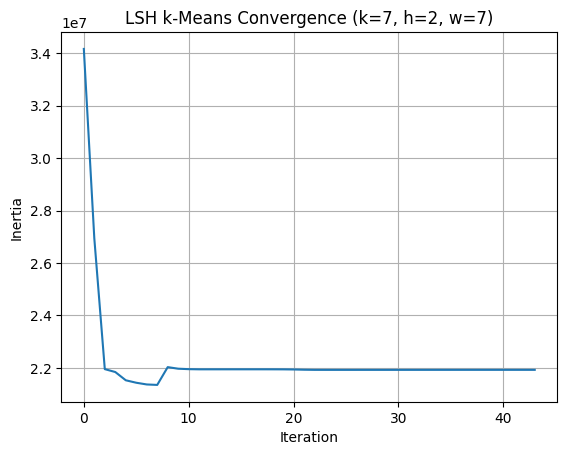


----- LSH k-Means Results (k=7, hashes=2, w=7) -----
Average NMI: 0.096
Average Runtime: 184.759 s
Average Iterations: 36
Average Distance Computations: 71766143
Total Distance Computations: 358830717
0
FOR EACH SAMPLE START
FOR EACH SAMPLE END
1
FOR EACH SAMPLE START
FOR EACH SAMPLE END
2
FOR EACH SAMPLE START
FOR EACH SAMPLE END
3
FOR EACH SAMPLE START
FOR EACH SAMPLE END
4
FOR EACH SAMPLE START
FOR EACH SAMPLE END
5
FOR EACH SAMPLE START
FOR EACH SAMPLE END
6
FOR EACH SAMPLE START
FOR EACH SAMPLE END
7
FOR EACH SAMPLE START
FOR EACH SAMPLE END
8
FOR EACH SAMPLE START
FOR EACH SAMPLE END
9
FOR EACH SAMPLE START
FOR EACH SAMPLE END
10
FOR EACH SAMPLE START
FOR EACH SAMPLE END
11
FOR EACH SAMPLE START
FOR EACH SAMPLE END
12
FOR EACH SAMPLE START
FOR EACH SAMPLE END
13
FOR EACH SAMPLE START
FOR EACH SAMPLE END
14
FOR EACH SAMPLE START
FOR EACH SAMPLE END
15
FOR EACH SAMPLE START
FOR EACH SAMPLE END
16
FOR EACH SAMPLE START
FOR EACH SAMPLE END
17
FOR EACH SAMPLE START
FOR EACH SAMPLE EN

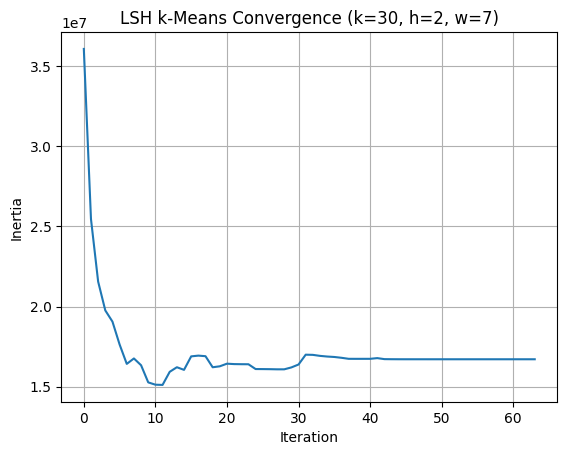


----- LSH k-Means Results (k=30, hashes=2, w=7) -----
Average NMI: 0.121
Average Runtime: 543.440 s
Average Iterations: 52
Average Distance Computations: 224827994
Total Distance Computations: 1124139971
0.15958984747435045


In [7]:
# We need to run the above for both 7 and 30 clusters
run_kmeans_lsh_evaluation(X, y, k=7)
#run_kmeans_lsh_evaluation(X, y, k=7, w=10)
#run_kmeans_lsh_evaluation(X, y, k=7, w=15)
#run_kmeans_lsh_evaluation(X, y, k=7, w=25)
#run_kmeans_lsh_evaluation(X, y, k=7, w=40)
#run_kmeans_lsh_evaluation(X, y, k=7, num_hashes=3)
#run_kmeans_lsh_evaluation(X, y, k=7, num_hashes=1)
run_kmeans_lsh_evaluation(X, y, k=30)

kmeans = KMeans(n_clusters=7).fit(X)
print(normalized_mutual_info_score(y, kmeans.labels_, average_method="arithmetic"))
#kmeans = KMeans(n_clusters=30).fit(X)
#print(normalized_mutual_info_score(y, kmeans.labels_, average_method="arithmetic"))

ALL FOR 2 TABLES

----- LSH k-Means Results (k=7, hashes=2, w=5) -----
Average NMI: 0.073
Average Runtime: 414.434 s
Average Iterations: 40
Average Distance Computations: 86429060
0.1643333699215231

----- LSH k-Means Results (k=7, hashes=2, w=3) -----
Average NMI: 0.096
Average Runtime: 239.361 s
Average Iterations: 27
Average Distance Computations: 74415298
0.1607774921986734

----- LSH k-Means Results (k=7, hashes=3, w=3) -----
Average NMI: 0.153
Average Runtime: 506.387 s
Average Iterations: 45
Average Distance Computations: 164298580

---- LSH k-Means Results (k=7, hashes=1, w=3) -----
Average NMI: 0.094
Average Runtime: 168.691 s
Average Iterations: 28
Average Distance Computations: 50366962
0.16528950882091115

ALL FOR 3 TABLES

----- LSH k-Means Results (k=7, hashes=3, w=3) -----
Average NMI: 0.093
Average Runtime: 531.700 s
Average Iterations: 50
Average Distance Computations: 168445375

----- LSH k-Means Results (k=7, hashes=1, w=3) -----
Average NMI: 0.091
Average Runtime: 344.793 s
Average Iterations: 50
Average Distance Computations: 101207013
0.17980194878457087


80 MAX

----- LSH k-Means Results (k=7, hashes=3, w=3) -----
Average NMI: 0.141
Average Runtime: 421.837 s
Average Iterations: 41
Average Distance Computations: 132994190

----- LSH k-Means Results (k=7, hashes=1, w=3) -----
Average NMI: 0.076
Average Runtime: 312.353 s
Average Iterations: 42
Average Distance Computations: 93251672
0.16817663705590885


207421284
168445375
101207013
50366962
132994190
93251672
144111888
19464550

ALL FOR 1 TABLE

----- LSH k-Means Results (k=7, hashes=3, w=3) -----
Average NMI: 0.083
Average Runtime: 486.616 s
Average Iterations: 37
Average Distance Computations: 144111888

----- LSH k-Means Results (k=7, hashes=1, w=3) -----
Average NMI: 0.034
Average Runtime: 88.590 s
Average Iterations: 22
Average Distance Computations: 19464550
0.15885531392968882






hash 2, tables 2,:
***** BEST *****
----- LSH k-Means Results (k=7, hashes=2, w=7) -----
Average NMI: 0.131
Average Runtime: 277.823 s
Average Iterations: 39
Average Distance Computations: 84284692

----- LSH k-Means Results (k=7, hashes=2, w=10) -----
Average NMI: 0.086
Average Runtime: 454.309 s
Average Iterations: 59
Average Distance Computations: 141294933

----- LSH k-Means Results (k=7, hashes=2, w=15) -----
Average NMI: 0.085
Average Runtime: 365.917 s
Average Iterations: 41
Average Distance Computations: 114130498

----- LSH k-Means Results (k=7, hashes=2, w=25) -----
Average NMI: 0.063
Average Runtime: 153.386 s
Average Iterations: 28
Average Distance Computations: 44738365

----- LSH k-Means Results (k=7, hashes=2, w=40) -----
Average NMI: 0.079
Average Runtime: 749.767 s
Average Iterations: 80
Average Distance Computations: 229697600

4 4
----- LSH k-Means Results (k=7, hashes=4, w=7) -----
Average NMI: 0.115
Average Runtime: 840.723 s
Average Iterations: 71
Average Distance Computations: 160483240
0.16392792303852882

----- LSH k-Means Results (k=7, hashes=2, w=7) -----
Average NMI: 0.088
Average Runtime: 368.774 s
Average Iterations: 51
Average Distance Computations: 96431571


----- LSH k-Means Results (k=30, hashes=2, w=7) -----
Average NMI: 0.115
Average Runtime: 801.440 s
Average Iterations: 52
Average Distance Computations: 232682234


----- LSH k-Means Results (k=7, hashes=2, w=7) -----
Average NMI: 0.090
Average Runtime: 404.171 s
Average Iterations: 54
Average Distance Computations: 101628050
Total Distance Computations: 508140254

----- LSH k-Means Results (k=30, hashes=2, w=7) -----
Average NMI: 0.125
Average Runtime: 653.186 s
Average Iterations: 41
Average Distance Computations: 168501604
Total Distance Computations: 842508022

0.09828035555038524

# PART 3 (k-means with coresets)

In [8]:
# based on Algorithm 1, https://dl.acm.org/doi/10.1145/3219819.3219973
def generate_coreset(X:np.ndarray, y=None, m:int=100):
    mu = np.mean(X,axis=0)
    # required to prevent recalculation for sum
    norm_d_X_mu = np.linalg.norm((X - mu),ord=2, axis=1)
    sum_norm_d_X_mu_squared = np.sum(norm_d_X_mu * norm_d_X_mu)

    q = []
    
    for norm_d_x_mu in norm_d_X_mu:
        
        q_x = 0.5 * (1.0/X.shape[0]) + 0.5 * ((norm_d_x_mu * norm_d_x_mu)/sum_norm_d_X_mu_squared)
        q.append(q_x)

    q = np.array(q)

    sample_indices = np.random.choice(X.shape[0], size=m, replace=False, p=q)

    weights = 1/(m*q[sample_indices])
    sampled_points = weights[:,np.newaxis] * X[sample_indices]
    
    if y is not None: 
        return sampled_points, y[sample_indices]

    return sampled_points

def run_kmeans_coresets_evaluation(X, y, k, runs=10, m_values=[100,1000,10_000]):
    for m in m_values:
        nmi_scores = []
        runtimes = []
        iterations_list = []
        dist_counts = []
        accuracy = []
        for _ in range(runs):
            start_time = time.time()
            coreset_X, coreset_y = generate_coreset(X,y,m)
            kmeans = KMeans(n_clusters=k).fit(coreset_X)
            end_time = time.time()
    
            nmi = normalized_mutual_info_score(coreset_y, kmeans.labels_, average_method="arithmetic")
            runtime = end_time - start_time

            
    
            nmi_scores.append(nmi)
            runtimes.append(runtime)
            iterations_list.append(kmeans.n_iter_)
            dist_counts.append(kmeans.inertia_)
            accuracy.append(float(np.sum(kmeans.labels_ == coreset_y))/float(m))

        print(f"\n------ Results for k={k}, m={m} ------")
        print(f"Average NMI: {np.mean(nmi_scores):.4f}")
        print(f"Variance NMI: {np.var(nmi_scores):.7f}")
        print(f"Average Accuracy: {np.mean(accuracy):.4f}")
        print(f"Variance Accuracy: {np.var(accuracy):.7f}")
        print(f"Average Runtime: {np.mean(runtimes):.4f} s")
        print(f"Average Iterations: {int(np.mean(iterations_list))}")
        print(f"Average Distance Computations: {int(np.mean(dist_counts))}")
        print(f"Total Distance Computations: {np.sum(dist_counts)}")

In [9]:
run_kmeans_coresets_evaluation(X, y, k=7)
run_kmeans_coresets_evaluation(X, y, k=30)


------ Results for k=7, m=100 ------
Average NMI: 0.1922
Variance NMI: 0.0012125
Average Accuracy: 0.1450
Variance Accuracy: 0.0082850
Average Runtime: 0.3180 s
Average Iterations: 4
Average Distance Computations: 93913668427
Total Distance Computations: 939136684278.0013

------ Results for k=7, m=1000 ------
Average NMI: 0.1210
Variance NMI: 0.0003457
Average Accuracy: 0.1633
Variance Accuracy: 0.0064440
Average Runtime: 0.3191 s
Average Iterations: 8
Average Distance Computations: 10427280004
Total Distance Computations: 104272800047.19977

------ Results for k=7, m=10000 ------
Average NMI: 0.1181
Variance NMI: 0.0002202
Average Accuracy: 0.1557
Variance Accuracy: 0.0048963
Average Runtime: 0.4235 s
Average Iterations: 11
Average Distance Computations: 1085446849
Total Distance Computations: 10854468490.967884

------ Results for k=30, m=100 ------
Average NMI: 0.3514
Variance NMI: 0.0011042
Average Accuracy: 0.0400
Variance Accuracy: 0.0010800
Average Runtime: 0.3162 s
Average It

# Summary Plot NMI and runtime

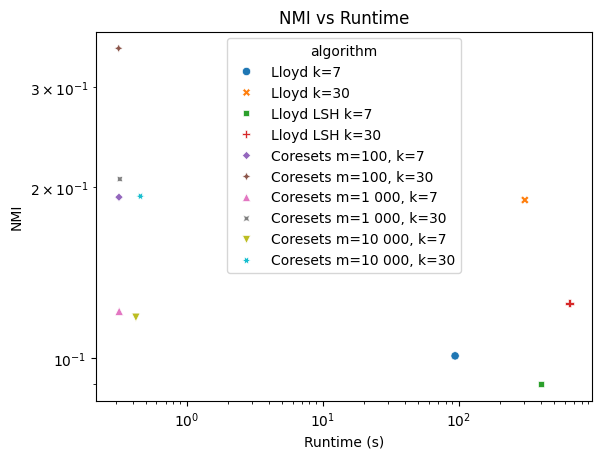

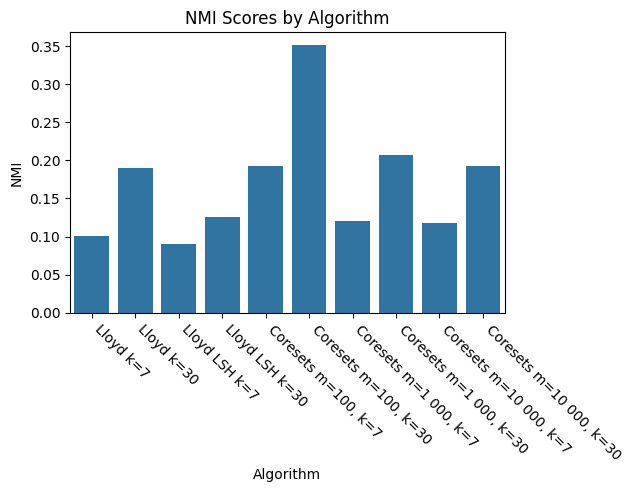

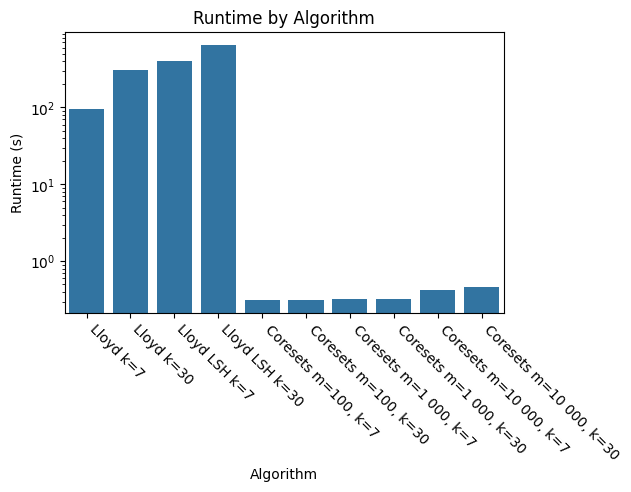

In [35]:
summary_plot = []

# data taken from values in report
summary_plot.append({ "algorithm" : "Lloyd k=7", "NMI" : 0.101, "runtime" : 94.092})
summary_plot.append({ "algorithm" : "Lloyd k=30", "NMI" : 0.190, "runtime" : 306.353})

summary_plot.append({ "algorithm" : "Lloyd LSH k=7", "NMI" : 0.090, "runtime" : 404.171})
summary_plot.append({ "algorithm" : "Lloyd LSH k=30", "NMI" : 0.125, "runtime" : 653.186})

summary_plot.append({ "algorithm" : "Coresets m=100, k=7", "NMI" : 0.1922, "runtime" : 0.3180})
summary_plot.append({ "algorithm" : "Coresets m=100, k=30", "NMI" : 0.3514, "runtime" : 0.3162})

summary_plot.append({ "algorithm" : "Coresets m=1 000, k=7", "NMI" : 0.1210, "runtime" : 0.3191})
summary_plot.append({ "algorithm" : "Coresets m=1 000, k=30", "NMI" : 0.2068, "runtime" : 0.3226})

summary_plot.append({ "algorithm" : "Coresets m=10 000, k=7", "NMI" : 0.1181, "runtime" : 0.4235})
summary_plot.append({ "algorithm" : "Coresets m=10 000, k=30", "NMI" : 0.1929, "runtime" : 0.4569})

summary_plot = pd.DataFrame(summary_plot)

sns.scatterplot(data=summary_plot, x="runtime", y="NMI", hue="algorithm", style="algorithm")

plt.xlabel("Runtime (s)")
plt.ylabel("NMI")
plt.title("NMI vs Runtime")
plt.xscale("log")
plt.yscale("log")
plt.savefig("summary_scatterplot.png", dpi=300)

plt.figure()
sns.barplot(data=summary_plot, x="algorithm", y="NMI")
plt.xticks(rotation=-45, ha='left')
plt.tight_layout()
plt.title("NMI Scores by Algorithm")
plt.ylabel("NMI")
plt.xlabel("Algorithm")
plt.savefig("nmi_barplot.png")

plt.figure()
sns.barplot(data=summary_plot, x="algorithm", y="runtime")
plt.xticks(rotation=-45, ha='left')
plt.tight_layout()
plt.title("Runtime by Algorithm")
plt.ylabel("Runtime (s)")
plt.xlabel("Algorithm")
plt.yscale("log")
plt.savefig("runtime_barplot.png")